# Notes 2 - Predictors of recorded DS live births

- Train from 2016 and ignore no_congen


## Preparation


In [1]:
import joblib, optuna, os, shap
import lightgbm as lgb
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from datetime import datetime
from lightgbm import early_stopping, log_evaluation
from scipy.spatial.distance import squareform
from scipy.cluster import hierarchy
from sklearn.inspection import permutation_importance
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    brier_score_loss,
    log_loss,
)
from sklearn.model_selection import train_test_split

import repl_utils, stats_utils, data_utils, ml_utils, plot_utils
from variables import Variables as vars

pd.options.mode.copy_on_write = True

plt.style.use("../../notebook.mplstyle")

os.makedirs("./output", exist_ok=True)

RANDOM_SEED = 47
np.random.seed(RANDOM_SEED)
rng = np.random.default_rng(RANDOM_SEED)

N_CORES = joblib.cpu_count(only_physical_cores=True)

START_TIME = datetime.now()

OUTPUT_DIR = f"output/0005-predictors-3/{START_TIME:%Y%m%d-%H%M%S}"

os.makedirs(OUTPUT_DIR, exist_ok=True)

repl_utils.print_environment_info()

print(f"\n--------------------\nOutput directory: {OUTPUT_DIR}\n--------------------\n")

-------------------- Environment Information --------------------
date: 2025-12-25T12:21:48.362540
platform: Windows-11-10.0.26220-SP0
platform_version: 10.0.26220
cpu: Intel64 Family 6 Model 197 Stepping 2, GenuineIntel
cores: 16
physical_cores: 16
ram: 95 GB
ram_available: 64 GB
cuda: False
cuda_device_count: 0
cuda_device_0: False
python: 3.13.11 | packaged by conda-forge | (main, Dec  6 2025, 11:10:00) [MSC v.1944 64 bit (AMD64)]
numpy: 2.3.5
pandas: 2.3.3
scipy: 1.16.3
sklearn: 1.8.0
lightgbm: 4.6.0
pytorch: 2.9.1
pymc: 5.27.0
pytensor: 2.36.1
arviz: 0.23.0

--------------------
Output directory: output/0005-predictors-3/20251225-122148
--------------------



### Options


In [2]:
START_YEAR = 2016
END_YEAR = 2024
# LightGBM threads
NUM_THREADS = N_CORES - 2
# Splitting data for training, validation and calibration
TRAINING_SPLIT = 0.5
VALIDATION_SPLIT = 0.25
CALIBRATION_SPLIT = 1 - TRAINING_SPLIT - VALIDATION_SPLIT
#
NUM_BOOST_ROUND = 10000
EARLY_STOPPING_ROUNDS = 20
# True to search for hyperparameters
SELECT_HYPERPARAMETERS = True
#
OPTIMIZE_TRIALS = 50

SAVE_PLOTS = True

### Load data


In [3]:
df = data_utils.load_predictors_data(from_year=START_YEAR, to_year=END_YEAR, include_unknown=False)

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

### Define initial feature set


In [4]:
numeric = [
    vars.YEAR,
    vars.DBWT,
    vars.PWGT_R,
    vars.WTGAIN,
    vars.BMI,
    vars.MAGE_C,
    vars.FAGECOMB,
]

categorical = [
    vars.DOB_MM,
    vars.DOB_WK,
    "dob_tt_pm",
    vars.BFACIL3,
    vars.SEX,
    vars.PRECARE,
    vars.GESTREC10,
    vars.RF_PDIAB,
    vars.RF_GDIAB,
    vars.RF_PHYPE,
    vars.RF_GHYPE,
    vars.RF_EHYPE,
    vars.RF_PPTERM,
    vars.RF_INFTR,
    vars.RF_FEDRG,
    vars.RF_ARTEC,
    vars.NO_RISKS,
    vars.LD_INDL,
    vars.LD_AUGM,
    vars.ME_PRES,
    vars.DMETH_REC,
    vars.APGAR5,
    vars.APGAR10,
    vars.AB_AVEN1,
    vars.AB_AVEN6,
    vars.AB_NICU,
    vars.AB_SURF,
    vars.AB_ANTI,
    vars.AB_SEIZ,
    vars.NO_ABNORM,
    vars.CA_ANEN,
    vars.CA_MNSB,
    vars.CA_CCHD,
    vars.CA_CDH,
    vars.CA_OMPH,
    vars.CA_GAST,
    vars.CA_LIMB,
    vars.CA_CLEFT,
    vars.CA_CLPAL,
    vars.CA_HYPO,
    vars.CA_DISOR,
    # vars.NO_CONGEN,
    vars.MEDUC,
    vars.MRACEHISP,
    vars.FEDUC,
    vars.FRACEHISP,
    vars.PAY_REC,
    vars.WIC,
]

features = categorical + numeric

X = df[features]
y = df["ca_down_c_p_n"]

X[categorical] = X[categorical].astype("category")

In [5]:
y

0           0
1           0
2           0
3           0
4           0
           ..
33527699    0
33527700    0
33527701    0
33527702    0
33527703    0
Name: ca_down_c_p_n, Length: 33527704, dtype: uint8

### Split training, validation and calibration data


In [6]:
# use half the data for the training set
X_train, X_tmp, y_train, y_tmp = train_test_split(
    X, y, test_size=TRAINING_SPLIT, stratify=y, random_state=RANDOM_SEED
)

# use a quarter of the data for training validation and a quarter for calibration
X_valid, X_cal, y_valid, y_cal = train_test_split(
    X_tmp,
    y_tmp,
    test_size=(VALIDATION_SPLIT / TRAINING_SPLIT),
    stratify=y_tmp,
    random_state=RANDOM_SEED,
)

train_data = lgb.Dataset(
    X_train, label=y_train, categorical_feature=categorical, free_raw_data=False
)

valid_data = lgb.Dataset(
    X_valid,
    label=y_valid,
    categorical_feature=categorical,
    reference=train_data,
    free_raw_data=False,
)

In [7]:
neg_count_train = y_train[y_train == 0].count()
pos_count_train = y_train[y_train == 1].count()
# scale_pos_weight = neg_count_train / pos_count_train

neg_count_valid = y_valid[y_valid == 0].count()
pos_count_valid = y_valid[y_valid == 1].count()

neg_count_cal = y_cal[y_cal == 0].count()
pos_count_cal = y_cal[y_cal == 1].count()

print(
    f"Training set: {neg_count_train} negatives, {pos_count_train} positives, probability positive {pos_count_train / neg_count_train:.8f}"
)
print(
    f"Validation set: {neg_count_valid} negatives, {pos_count_valid} positives, probability positive {pos_count_valid / neg_count_valid:.8f}"
)
print(
    f"Calibration set: {neg_count_cal} negatives, {pos_count_cal} positives, probability positive {pos_count_cal / neg_count_cal:.8f}"
)

Training set: 16754948 negatives, 8904 positives, probability positive 0.00053143
Validation set: 8377474 negatives, 4452 positives, probability positive 0.00053143
Calibration set: 8377473 negatives, 4453 positives, probability positive 0.00053154


In [8]:
base_params = {
    "objective": "binary",
    "metric": ["average_precision", "binary_logloss"],
    "boosting_type": "gbdt",
    "max_bin": 255,  # GPU 63/127; CPU 255
    # for now, we do not scale for better interpretability of outputs
    "scale_pos_weight": 1,
    "force_col_wise": True,
    "seed": RANDOM_SEED,
    "num_threads": NUM_THREADS,
    "verbosity": 1,
}

last_best_params = {    
    "learning_rate": 0.030669458443353795,
    "num_leaves": 377,
    "min_data_in_leaf": 888,
    "min_gain_to_split": 0.29725809979979523,
    "feature_fraction": 0.8225053633083914,
    "bagging_fraction": 0.792161251586521,
    "bagging_freq": 4,
    "lambda_l1": 0.4843437977635669,
    "lambda_l2": 0.4544191696235093,
}

## Hyperparameter tuning


In [9]:
def objective(trial):
    trial_params = {
        # required to change min_data_in_leaf across trials without rebuilding the Dataset
        "feature_pre_filter": False,
        # Speed / stability
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.5, log=True),
        # Tree complexity
        "num_leaves": trial.suggest_int("num_leaves", 32, 512, log=True),
        "min_data_in_leaf": trial.suggest_int("min_data_in_leaf", 500, 10000, log=True),
        "min_gain_to_split": trial.suggest_float("min_gain_to_split", 0.0, 1.0),
        # Sampling
        "feature_fraction": trial.suggest_float("feature_fraction", 0.6, 1.0),
        "bagging_fraction": trial.suggest_float("bagging_fraction", 0.6, 1.0),
        "bagging_freq": trial.suggest_int("bagging_freq", 1, 10),
        # Regularization
        "lambda_l1": trial.suggest_float("lambda_l1", 1e-8, 10.0, log=True),
        "lambda_l2": trial.suggest_float("lambda_l2", 1e-8, 10.0, log=True),
    }

    # Merge: base_params always present; trial_params override if same key exists
    params = {**base_params, **trial_params}

    pruning_cb = optuna.integration.LightGBMPruningCallback(trial, "average_precision")

    gbm = lgb.train(
        params,
        train_data,
        num_boost_round=NUM_BOOST_ROUND,
        valid_sets=[valid_data],
        callbacks=[
            lgb.early_stopping(stopping_rounds=EARLY_STOPPING_ROUNDS),
            lgb.log_evaluation(period=10),
            pruning_cb,
        ],
    )

    # Best score on validation
    return gbm.best_score["valid_0"]["average_precision"]


if SELECT_HYPERPARAMETERS:
    study = optuna.create_study(
        direction="maximize",
        sampler=optuna.samplers.TPESampler(),
        pruner=optuna.pruners.HyperbandPruner(),
    )

    study.optimize(objective, n_trials=OPTIMIZE_TRIALS)

    print(study.best_params, study.best_value)

    best = study.best_params
else:
    best = last_best_params

# Merge (best overrides base if there are collisions)
params = {**base_params, **best}
params["feature_pre_filter"] = True  # reset to default for final training

print("Parameters for training:")
for k, v in params.items():
    print(f'  "{k}": {v}')

[I 2025-12-25 12:22:56,284] A new study created in memory with name: no-name-7dc2bca3-b71f-442b-8f16-c5ec4faa84f0


[LightGBM] [Info] Number of positive: 8904, number of negative: 16754948
[LightGBM] [Info] Total Bins 1155
[LightGBM] [Info] Number of data points in the train set: 16763852, number of used features: 54
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000531 -> initscore=-7.539948
[LightGBM] [Info] Start training from score -7.539948
Training until validation scores don't improve for 20 rounds
[10]	valid_0's average_precision: 0.0228133	valid_0's binary_logloss: 0.00398529
[20]	valid_0's average_precision: 0.0243019	valid_0's binary_logloss: 0.00384336
[30]	valid_0's average_precision: 0.0251608	valid_0's binary_logloss: 0.00376947
[40]	valid_0's average_precision: 0.0258017	valid_0's binary_logloss: 0.00372405
[50]	valid_0's average_precision: 0.026334	valid_0's binary_logloss: 0.00369336
[60]	valid_0's average_precision: 0.0267018	valid_0's binary_logloss: 0.00367294
[70]	valid_0's average_precision: 0.0270688	valid_0's binary_logloss: 0.00365826
[80]	valid_0's average_precision: 0.

[I 2025-12-25 12:25:58,662] Trial 0 finished with value: 0.028348447626100167 and parameters: {'learning_rate': 0.031392985886266316, 'num_leaves': 33, 'min_data_in_leaf': 9740, 'min_gain_to_split': 0.5896709266941496, 'feature_fraction': 0.7621588459859558, 'bagging_fraction': 0.6080604707574864, 'bagging_freq': 2, 'lambda_l1': 4.6318061789721695e-05, 'lambda_l2': 2.591355411342641e-06}. Best is trial 0 with value: 0.028348447626100167.


[190]	valid_0's average_precision: 0.0283381	valid_0's binary_logloss: 0.00361548
Early stopping, best iteration is:
[170]	valid_0's average_precision: 0.0283484	valid_0's binary_logloss: 0.00361714
[LightGBM] [Info] Number of positive: 8904, number of negative: 16754948
[LightGBM] [Info] Total Bins 1155
[LightGBM] [Info] Number of data points in the train set: 16763852, number of used features: 54
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000531 -> initscore=-7.539948
[LightGBM] [Info] Start training from score -7.539948
Training until validation scores don't improve for 20 rounds
[10]	valid_0's average_precision: 0.00913497	valid_0's binary_logloss: 0.00516331
[20]	valid_0's average_precision: 0.0102365	valid_0's binary_logloss: 0.00503672


[I 2025-12-25 12:26:15,149] Trial 1 finished with value: 0.016125527349552304 and parameters: {'learning_rate': 0.15434299574898222, 'num_leaves': 41, 'min_data_in_leaf': 520, 'min_gain_to_split': 0.7109453785307732, 'feature_fraction': 0.8421333465217926, 'bagging_fraction': 0.8223863561607285, 'bagging_freq': 5, 'lambda_l1': 5.60474310622449e-05, 'lambda_l2': 9.782431490548026e-08}. Best is trial 0 with value: 0.028348447626100167.


Early stopping, best iteration is:
[1]	valid_0's average_precision: 0.0161255	valid_0's binary_logloss: 0.0133541
[LightGBM] [Info] Number of positive: 8904, number of negative: 16754948
[LightGBM] [Info] Total Bins 1155
[LightGBM] [Info] Number of data points in the train set: 16763852, number of used features: 54
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000531 -> initscore=-7.539948
[LightGBM] [Info] Start training from score -7.539948
Training until validation scores don't improve for 20 rounds


[I 2025-12-25 12:26:19,406] Trial 2 pruned. Trial was pruned at iteration 3.


[LightGBM] [Info] Number of positive: 8904, number of negative: 16754948
[LightGBM] [Info] Total Bins 1155
[LightGBM] [Info] Number of data points in the train set: 16763852, number of used features: 54
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000531 -> initscore=-7.539948
[LightGBM] [Info] Start training from score -7.539948
Training until validation scores don't improve for 20 rounds
[10]	valid_0's average_precision: 0.00409209	valid_0's binary_logloss: 0.0410585
[20]	valid_0's average_precision: 0.00415752	valid_0's binary_logloss: 0.0122136


[I 2025-12-25 12:26:39,417] Trial 3 finished with value: 0.013094928660124775 and parameters: {'learning_rate': 0.3396399726164668, 'num_leaves': 157, 'min_data_in_leaf': 597, 'min_gain_to_split': 0.9143014659994003, 'feature_fraction': 0.7218585506271948, 'bagging_fraction': 0.7870565820652694, 'bagging_freq': 1, 'lambda_l1': 0.04091757281646336, 'lambda_l2': 0.0007268984225543042}. Best is trial 0 with value: 0.028348447626100167.


Early stopping, best iteration is:
[3]	valid_0's average_precision: 0.0130949	valid_0's binary_logloss: 0.0180499
[LightGBM] [Info] Number of positive: 8904, number of negative: 16754948
[LightGBM] [Info] Total Bins 1155
[LightGBM] [Info] Number of data points in the train set: 16763852, number of used features: 54
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000531 -> initscore=-7.539948
[LightGBM] [Info] Start training from score -7.539948
Training until validation scores don't improve for 20 rounds
[10]	valid_0's average_precision: 0.0243988	valid_0's binary_logloss: 0.00394827
[20]	valid_0's average_precision: 0.0266746	valid_0's binary_logloss: 0.00378316
[30]	valid_0's average_precision: 0.0275068	valid_0's binary_logloss: 0.00371083
[40]	valid_0's average_precision: 0.0277441	valid_0's binary_logloss: 0.00367921
[50]	valid_0's average_precision: 0.0282901	valid_0's binary_logloss: 0.0036593
[60]	valid_0's average_precision: 0.0287889	valid_0's binary_logloss: 0.00364924
[70

[I 2025-12-25 12:28:31,553] Trial 4 finished with value: 0.02909843927830824 and parameters: {'learning_rate': 0.05649034150456727, 'num_leaves': 258, 'min_data_in_leaf': 838, 'min_gain_to_split': 0.7621803738181396, 'feature_fraction': 0.7163693686804442, 'bagging_fraction': 0.9978547132094999, 'bagging_freq': 3, 'lambda_l1': 0.011190798007970659, 'lambda_l2': 0.14780089161533785}. Best is trial 4 with value: 0.02909843927830824.


Early stopping, best iteration is:
[74]	valid_0's average_precision: 0.0290984	valid_0's binary_logloss: 0.00364363
[LightGBM] [Info] Number of positive: 8904, number of negative: 16754948
[LightGBM] [Info] Total Bins 1155
[LightGBM] [Info] Number of data points in the train set: 16763852, number of used features: 54
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000531 -> initscore=-7.539948
[LightGBM] [Info] Start training from score -7.539948
Training until validation scores don't improve for 20 rounds


[I 2025-12-25 12:28:34,751] Trial 5 pruned. Trial was pruned at iteration 3.


[LightGBM] [Info] Number of positive: 8904, number of negative: 16754948
[LightGBM] [Info] Total Bins 1155
[LightGBM] [Info] Number of data points in the train set: 16763852, number of used features: 54
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000531 -> initscore=-7.539948
[LightGBM] [Info] Start training from score -7.539948
Training until validation scores don't improve for 20 rounds


[I 2025-12-25 12:28:38,261] Trial 6 pruned. Trial was pruned at iteration 3.


[LightGBM] [Info] Number of positive: 8904, number of negative: 16754948
[LightGBM] [Info] Total Bins 1155
[LightGBM] [Info] Number of data points in the train set: 16763852, number of used features: 54
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000531 -> initscore=-7.539948
[LightGBM] [Info] Start training from score -7.539948
Training until validation scores don't improve for 20 rounds
[10]	valid_0's average_precision: 0.0244875	valid_0's binary_logloss: 0.00418255
[20]	valid_0's average_precision: 0.0260312	valid_0's binary_logloss: 0.00405679
[30]	valid_0's average_precision: 0.0270537	valid_0's binary_logloss: 0.00397559
[40]	valid_0's average_precision: 0.0276818	valid_0's binary_logloss: 0.00391653
[50]	valid_0's average_precision: 0.0280482	valid_0's binary_logloss: 0.00387105
[60]	valid_0's average_precision: 0.0283384	valid_0's binary_logloss: 0.003835
[70]	valid_0's average_precision: 0.0286338	valid_0's binary_logloss: 0.00380515
[80]	valid_0's average_precision: 0.0

[I 2025-12-25 12:39:19,241] Trial 7 finished with value: 0.03205993842560169 and parameters: {'learning_rate': 0.010312523026211521, 'num_leaves': 33, 'min_data_in_leaf': 1444, 'min_gain_to_split': 0.8300668397659425, 'feature_fraction': 0.9798409266070187, 'bagging_fraction': 0.690894401223741, 'bagging_freq': 1, 'lambda_l1': 7.781668055547625, 'lambda_l2': 2.6611258108961745e-05}. Best is trial 7 with value: 0.03205993842560169.


Early stopping, best iteration is:
[705]	valid_0's average_precision: 0.0320599	valid_0's binary_logloss: 0.00360207
[LightGBM] [Info] Number of positive: 8904, number of negative: 16754948
[LightGBM] [Info] Total Bins 1155
[LightGBM] [Info] Number of data points in the train set: 16763852, number of used features: 54
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000531 -> initscore=-7.539948
[LightGBM] [Info] Start training from score -7.539948
Training until validation scores don't improve for 20 rounds


[I 2025-12-25 12:39:21,306] Trial 8 pruned. Trial was pruned at iteration 1.


[LightGBM] [Info] Number of positive: 8904, number of negative: 16754948
[LightGBM] [Info] Total Bins 1155
[LightGBM] [Info] Number of data points in the train set: 16763852, number of used features: 54
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000531 -> initscore=-7.539948
[LightGBM] [Info] Start training from score -7.539948
Training until validation scores don't improve for 20 rounds


[I 2025-12-25 12:39:23,588] Trial 9 pruned. Trial was pruned at iteration 1.


[LightGBM] [Info] Number of positive: 8904, number of negative: 16754948
[LightGBM] [Info] Total Bins 1155
[LightGBM] [Info] Number of data points in the train set: 16763852, number of used features: 54
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000531 -> initscore=-7.539948
[LightGBM] [Info] Start training from score -7.539948
Training until validation scores don't improve for 20 rounds


[I 2025-12-25 12:39:26,009] Trial 10 pruned. Trial was pruned at iteration 1.


[LightGBM] [Info] Number of positive: 8904, number of negative: 16754948
[LightGBM] [Info] Total Bins 1155
[LightGBM] [Info] Number of data points in the train set: 16763852, number of used features: 54
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000531 -> initscore=-7.539948
[LightGBM] [Info] Start training from score -7.539948
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 20 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[L

[I 2025-12-25 12:43:55,991] Trial 11 finished with value: 0.029127651632280604 and parameters: {'learning_rate': 0.035390764029521043, 'num_leaves': 464, 'min_data_in_leaf': 1069, 'min_gain_to_split': 0.6990796550566059, 'feature_fraction': 0.9094079942279958, 'bagging_fraction': 0.9981466464399736, 'bagging_freq': 3, 'lambda_l1': 9.224701314308765, 'lambda_l2': 0.15925550943751177}. Best is trial 7 with value: 0.03205993842560169.


Early stopping, best iteration is:
[226]	valid_0's average_precision: 0.0291277	valid_0's binary_logloss: 0.00361324
[LightGBM] [Info] Number of positive: 8904, number of negative: 16754948
[LightGBM] [Info] Total Bins 1155
[LightGBM] [Info] Number of data points in the train set: 16763852, number of used features: 54
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000531 -> initscore=-7.539948
[LightGBM] [Info] Start training from score -7.539948
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 20 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further spl

[I 2025-12-25 12:52:39,687] Trial 12 finished with value: 0.03241739682776711 and parameters: {'learning_rate': 0.010270145405128701, 'num_leaves': 504, 'min_data_in_leaf': 1160, 'min_gain_to_split': 0.5458954222483211, 'feature_fraction': 0.9227825518291345, 'bagging_fraction': 0.994177396958003, 'bagging_freq': 3, 'lambda_l1': 9.60640817111434, 'lambda_l2': 0.04248678283923529}. Best is trial 12 with value: 0.03241739682776711.


Early stopping, best iteration is:
[436]	valid_0's average_precision: 0.0324174	valid_0's binary_logloss: 0.00360383
[LightGBM] [Info] Number of positive: 8904, number of negative: 16754948
[LightGBM] [Info] Total Bins 1155
[LightGBM] [Info] Number of data points in the train set: 16763852, number of used features: 54
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000531 -> initscore=-7.539948
[LightGBM] [Info] Start training from score -7.539948
Training until validation scores don't improve for 20 rounds


[I 2025-12-25 12:52:50,404] Trial 13 pruned. Trial was pruned at iteration 9.


[LightGBM] [Info] Number of positive: 8904, number of negative: 16754948
[LightGBM] [Info] Total Bins 1155
[LightGBM] [Info] Number of data points in the train set: 16763852, number of used features: 54
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000531 -> initscore=-7.539948
[LightGBM] [Info] Start training from score -7.539948
Training until validation scores don't improve for 20 rounds
[10]	valid_0's average_precision: 0.0276277	valid_0's binary_logloss: 0.00405236
[20]	valid_0's average_precision: 0.0290162	valid_0's binary_logloss: 0.00391527
[30]	valid_0's average_precision: 0.0296524	valid_0's binary_logloss: 0.00383429
[40]	valid_0's average_precision: 0.0301637	valid_0's binary_logloss: 0.00377971
[50]	valid_0's average_precision: 0.0305273	valid_0's binary_logloss: 0.00374114
[60]	valid_0's average_precision: 0.0309733	valid_0's binary_logloss: 0.0037123
[70]	valid_0's average_precision: 0.0312813	valid_0's binary_logloss: 0.00369028
[80]	valid_0's average_precision: 0.

[I 2025-12-25 12:57:32,943] Trial 14 finished with value: 0.032359360171623414 and parameters: {'learning_rate': 0.0186061316220164, 'num_leaves': 59, 'min_data_in_leaf': 3006, 'min_gain_to_split': 0.18745425148180084, 'feature_fraction': 0.9285994635477955, 'bagging_fraction': 0.7555621531151794, 'bagging_freq': 2, 'lambda_l1': 0.2888147526767551, 'lambda_l2': 0.025158404281043486}. Best is trial 12 with value: 0.03241739682776711.


Early stopping, best iteration is:
[265]	valid_0's average_precision: 0.0323594	valid_0's binary_logloss: 0.00360784
[LightGBM] [Info] Number of positive: 8904, number of negative: 16754948
[LightGBM] [Info] Total Bins 1155
[LightGBM] [Info] Number of data points in the train set: 16763852, number of used features: 54
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000531 -> initscore=-7.539948
[LightGBM] [Info] Start training from score -7.539948
Training until validation scores don't improve for 20 rounds


[I 2025-12-25 12:57:36,173] Trial 15 pruned. Trial was pruned at iteration 3.


[LightGBM] [Info] Number of positive: 8904, number of negative: 16754948
[LightGBM] [Info] Total Bins 1155
[LightGBM] [Info] Number of data points in the train set: 16763852, number of used features: 54
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000531 -> initscore=-7.539948
[LightGBM] [Info] Start training from score -7.539948
Training until validation scores don't improve for 20 rounds


[I 2025-12-25 12:57:38,714] Trial 16 pruned. Trial was pruned at iteration 1.


[LightGBM] [Info] Number of positive: 8904, number of negative: 16754948
[LightGBM] [Info] Total Bins 1155
[LightGBM] [Info] Number of data points in the train set: 16763852, number of used features: 54
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000531 -> initscore=-7.539948
[LightGBM] [Info] Start training from score -7.539948
Training until validation scores don't improve for 20 rounds


[I 2025-12-25 12:57:40,854] Trial 17 pruned. Trial was pruned at iteration 1.


[LightGBM] [Info] Number of positive: 8904, number of negative: 16754948
[LightGBM] [Info] Total Bins 1155
[LightGBM] [Info] Number of data points in the train set: 16763852, number of used features: 54
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000531 -> initscore=-7.539948
[LightGBM] [Info] Start training from score -7.539948
Training until validation scores don't improve for 20 rounds


[I 2025-12-25 12:57:45,084] Trial 18 pruned. Trial was pruned at iteration 3.


[LightGBM] [Info] Number of positive: 8904, number of negative: 16754948
[LightGBM] [Info] Total Bins 1155
[LightGBM] [Info] Number of data points in the train set: 16763852, number of used features: 54
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000531 -> initscore=-7.539948
[LightGBM] [Info] Start training from score -7.539948
Training until validation scores don't improve for 20 rounds


[I 2025-12-25 12:57:47,195] Trial 19 pruned. Trial was pruned at iteration 1.


[LightGBM] [Info] Number of positive: 8904, number of negative: 16754948
[LightGBM] [Info] Total Bins 1155
[LightGBM] [Info] Number of data points in the train set: 16763852, number of used features: 54
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000531 -> initscore=-7.539948
[LightGBM] [Info] Start training from score -7.539948
Training until validation scores don't improve for 20 rounds


[I 2025-12-25 12:57:51,272] Trial 20 pruned. Trial was pruned at iteration 3.


[LightGBM] [Info] Number of positive: 8904, number of negative: 16754948
[LightGBM] [Info] Total Bins 1155
[LightGBM] [Info] Number of data points in the train set: 16763852, number of used features: 54
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000531 -> initscore=-7.539948
[LightGBM] [Info] Start training from score -7.539948
Training until validation scores don't improve for 20 rounds


[I 2025-12-25 12:57:57,029] Trial 21 pruned. Trial was pruned at iteration 9.


[LightGBM] [Info] Number of positive: 8904, number of negative: 16754948
[LightGBM] [Info] Total Bins 1155
[LightGBM] [Info] Number of data points in the train set: 16763852, number of used features: 54
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000531 -> initscore=-7.539948
[LightGBM] [Info] Start training from score -7.539948
Training until validation scores don't improve for 20 rounds


[I 2025-12-25 12:58:04,379] Trial 22 pruned. Trial was pruned at iteration 9.


[LightGBM] [Info] Number of positive: 8904, number of negative: 16754948
[LightGBM] [Info] Total Bins 1155
[LightGBM] [Info] Number of data points in the train set: 16763852, number of used features: 54
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000531 -> initscore=-7.539948
[LightGBM] [Info] Start training from score -7.539948
Training until validation scores don't improve for 20 rounds


[I 2025-12-25 12:58:07,401] Trial 23 pruned. Trial was pruned at iteration 3.


[LightGBM] [Info] Number of positive: 8904, number of negative: 16754948
[LightGBM] [Info] Total Bins 1155
[LightGBM] [Info] Number of data points in the train set: 16763852, number of used features: 54
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000531 -> initscore=-7.539948
[LightGBM] [Info] Start training from score -7.539948
Training until validation scores don't improve for 20 rounds
[10]	valid_0's average_precision: 0.027659	valid_0's binary_logloss: 0.00409649
[20]	valid_0's average_precision: 0.0284925	valid_0's binary_logloss: 0.00396313
[30]	valid_0's average_precision: 0.0287736	valid_0's binary_logloss: 0.00388242
[40]	valid_0's average_precision: 0.029097	valid_0's binary_logloss: 0.00382407
[50]	valid_0's average_precision: 0.029382	valid_0's binary_logloss: 0.00378277
[60]	valid_0's average_precision: 0.0297793	valid_0's binary_logloss: 0.0037501
[70]	valid_0's average_precision: 0.0300221	valid_0's binary_logloss: 0.00372418
[80]	valid_0's average_precision: 0.030

[I 2025-12-25 13:01:23,122] Trial 24 pruned. Trial was pruned at iteration 243.


[LightGBM] [Info] Number of positive: 8904, number of negative: 16754948
[LightGBM] [Info] Total Bins 1155
[LightGBM] [Info] Number of data points in the train set: 16763852, number of used features: 54
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000531 -> initscore=-7.539948
[LightGBM] [Info] Start training from score -7.539948
Training until validation scores don't improve for 20 rounds


[I 2025-12-25 13:01:26,394] Trial 25 pruned. Trial was pruned at iteration 3.


[LightGBM] [Info] Number of positive: 8904, number of negative: 16754948
[LightGBM] [Info] Total Bins 1155
[LightGBM] [Info] Number of data points in the train set: 16763852, number of used features: 54
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000531 -> initscore=-7.539948
[LightGBM] [Info] Start training from score -7.539948
Training until validation scores don't improve for 20 rounds


[I 2025-12-25 13:01:28,430] Trial 26 pruned. Trial was pruned at iteration 1.


[LightGBM] [Info] Number of positive: 8904, number of negative: 16754948
[LightGBM] [Info] Total Bins 1155
[LightGBM] [Info] Number of data points in the train set: 16763852, number of used features: 54
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000531 -> initscore=-7.539948
[LightGBM] [Info] Start training from score -7.539948
Training until validation scores don't improve for 20 rounds


[I 2025-12-25 13:01:37,389] Trial 27 pruned. Trial was pruned at iteration 9.


[LightGBM] [Info] Number of positive: 8904, number of negative: 16754948
[LightGBM] [Info] Total Bins 1155
[LightGBM] [Info] Number of data points in the train set: 16763852, number of used features: 54
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000531 -> initscore=-7.539948
[LightGBM] [Info] Start training from score -7.539948
Training until validation scores don't improve for 20 rounds


[I 2025-12-25 13:01:40,127] Trial 28 pruned. Trial was pruned at iteration 3.


[LightGBM] [Info] Number of positive: 8904, number of negative: 16754948
[LightGBM] [Info] Total Bins 1155
[LightGBM] [Info] Number of data points in the train set: 16763852, number of used features: 54
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000531 -> initscore=-7.539948
[LightGBM] [Info] Start training from score -7.539948
Training until validation scores don't improve for 20 rounds


[I 2025-12-25 13:01:41,935] Trial 29 pruned. Trial was pruned at iteration 1.


[LightGBM] [Info] Number of positive: 8904, number of negative: 16754948
[LightGBM] [Info] Total Bins 1155
[LightGBM] [Info] Number of data points in the train set: 16763852, number of used features: 54
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000531 -> initscore=-7.539948
[LightGBM] [Info] Start training from score -7.539948
Training until validation scores don't improve for 20 rounds


[I 2025-12-25 13:01:43,942] Trial 30 pruned. Trial was pruned at iteration 1.


[LightGBM] [Info] Number of positive: 8904, number of negative: 16754948
[LightGBM] [Info] Total Bins 1155
[LightGBM] [Info] Number of data points in the train set: 16763852, number of used features: 54
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000531 -> initscore=-7.539948
[LightGBM] [Info] Start training from score -7.539948
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 20 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[I 2025-12-25 13:01:47,971] Trial 31 pruned. Trial was pruned at iteration 3.


[LightGBM] [Info] Number of positive: 8904, number of negative: 16754948
[LightGBM] [Info] Total Bins 1155
[LightGBM] [Info] Number of data points in the train set: 16763852, number of used features: 54
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000531 -> initscore=-7.539948
[LightGBM] [Info] Start training from score -7.539948
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 20 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[L

[I 2025-12-25 13:01:58,551] Trial 32 pruned. Trial was pruned at iteration 9.


[LightGBM] [Info] Number of positive: 8904, number of negative: 16754948
[LightGBM] [Info] Total Bins 1155
[LightGBM] [Info] Number of data points in the train set: 16763852, number of used features: 54
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000531 -> initscore=-7.539948
[LightGBM] [Info] Start training from score -7.539948
Training until validation scores don't improve for 20 rounds


[I 2025-12-25 13:02:01,239] Trial 33 pruned. Trial was pruned at iteration 1.


[LightGBM] [Info] Number of positive: 8904, number of negative: 16754948
[LightGBM] [Info] Total Bins 1155
[LightGBM] [Info] Number of data points in the train set: 16763852, number of used features: 54
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000531 -> initscore=-7.539948
[LightGBM] [Info] Start training from score -7.539948
Training until validation scores don't improve for 20 rounds
[10]	valid_0's average_precision: 0.0285257	valid_0's binary_logloss: 0.00412344
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[20]	valid_0's average_precision: 0.0299011	valid_0's binary_logloss: 0.00398847
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best g

[I 2025-12-25 13:05:23,051] Trial 34 finished with value: 0.032497839707308594 and parameters: {'learning_rate': 0.012778649429636564, 'num_leaves': 260, 'min_data_in_leaf': 546, 'min_gain_to_split': 0.508213242082094, 'feature_fraction': 0.8953363070358324, 'bagging_fraction': 0.8982842673883377, 'bagging_freq': 3, 'lambda_l1': 4.587234993941648, 'lambda_l2': 6.0380739648204436e-06}. Best is trial 34 with value: 0.032497839707308594.


Early stopping, best iteration is:
[161]	valid_0's average_precision: 0.0324978	valid_0's binary_logloss: 0.00363604
[LightGBM] [Info] Number of positive: 8904, number of negative: 16754948
[LightGBM] [Info] Total Bins 1155
[LightGBM] [Info] Number of data points in the train set: 16763852, number of used features: 54
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000531 -> initscore=-7.539948
[LightGBM] [Info] Start training from score -7.539948
Training until validation scores don't improve for 20 rounds


[I 2025-12-25 13:05:30,820] Trial 35 pruned. Trial was pruned at iteration 9.


[LightGBM] [Info] Number of positive: 8904, number of negative: 16754948
[LightGBM] [Info] Total Bins 1155
[LightGBM] [Info] Number of data points in the train set: 16763852, number of used features: 54
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000531 -> initscore=-7.539948
[LightGBM] [Info] Start training from score -7.539948
Training until validation scores don't improve for 20 rounds
[10]	valid_0's average_precision: 0.0267696	valid_0's binary_logloss: 0.00405049
[20]	valid_0's average_precision: 0.0271951	valid_0's binary_logloss: 0.00391673


[I 2025-12-25 13:05:54,677] Trial 36 pruned. Trial was pruned at iteration 27.


[LightGBM] [Info] Number of positive: 8904, number of negative: 16754948
[LightGBM] [Info] Total Bins 1155
[LightGBM] [Info] Number of data points in the train set: 16763852, number of used features: 54
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000531 -> initscore=-7.539948
[LightGBM] [Info] Start training from score -7.539948
Training until validation scores don't improve for 20 rounds
[10]	valid_0's average_precision: 0.0284337	valid_0's binary_logloss: 0.00414985
[20]	valid_0's average_precision: 0.0295091	valid_0's binary_logloss: 0.00401865
[30]	valid_0's average_precision: 0.0302788	valid_0's binary_logloss: 0.00393671
[40]	valid_0's average_precision: 0.0308544	valid_0's binary_logloss: 0.00387634
[50]	valid_0's average_precision: 0.0311484	valid_0's binary_logloss: 0.00383059
[60]	valid_0's average_precision: 0.0312652	valid_0's binary_logloss: 0.00379407
[70]	valid_0's average_precision: 0.0313892	valid_0's binary_logloss: 0.00376498
[80]	valid_0's average_precision: 0

[I 2025-12-25 13:10:54,262] Trial 37 finished with value: 0.03269927069411204 and parameters: {'learning_rate': 0.010902133177288791, 'num_leaves': 226, 'min_data_in_leaf': 585, 'min_gain_to_split': 0.5269538761412951, 'feature_fraction': 0.9295105863902624, 'bagging_fraction': 0.8764390386867382, 'bagging_freq': 5, 'lambda_l1': 3.3401990226749554, 'lambda_l2': 3.931394017313699e-06}. Best is trial 37 with value: 0.03269927069411204.


Early stopping, best iteration is:
[266]	valid_0's average_precision: 0.0326993	valid_0's binary_logloss: 0.00361565
[LightGBM] [Info] Number of positive: 8904, number of negative: 16754948
[LightGBM] [Info] Total Bins 1155
[LightGBM] [Info] Number of data points in the train set: 16763852, number of used features: 54
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000531 -> initscore=-7.539948
[LightGBM] [Info] Start training from score -7.539948
Training until validation scores don't improve for 20 rounds


[I 2025-12-25 13:10:58,344] Trial 38 pruned. Trial was pruned at iteration 3.


[LightGBM] [Info] Number of positive: 8904, number of negative: 16754948
[LightGBM] [Info] Total Bins 1155
[LightGBM] [Info] Number of data points in the train set: 16763852, number of used features: 54
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000531 -> initscore=-7.539948
[LightGBM] [Info] Start training from score -7.539948
Training until validation scores don't improve for 20 rounds


[I 2025-12-25 13:11:00,504] Trial 39 pruned. Trial was pruned at iteration 1.


[LightGBM] [Info] Number of positive: 8904, number of negative: 16754948
[LightGBM] [Info] Total Bins 1155
[LightGBM] [Info] Number of data points in the train set: 16763852, number of used features: 54
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000531 -> initscore=-7.539948
[LightGBM] [Info] Start training from score -7.539948
Training until validation scores don't improve for 20 rounds
[10]	valid_0's average_precision: 0.027365	valid_0's binary_logloss: 0.00411901
[20]	valid_0's average_precision: 0.0286504	valid_0's binary_logloss: 0.00398649


[I 2025-12-25 13:11:22,958] Trial 40 pruned. Trial was pruned at iteration 27.


[LightGBM] [Info] Number of positive: 8904, number of negative: 16754948
[LightGBM] [Info] Total Bins 1155
[LightGBM] [Info] Number of data points in the train set: 16763852, number of used features: 54
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000531 -> initscore=-7.539948
[LightGBM] [Info] Start training from score -7.539948
Training until validation scores don't improve for 20 rounds
[10]	valid_0's average_precision: 0.027447	valid_0's binary_logloss: 0.0041642
[20]	valid_0's average_precision: 0.0288185	valid_0's binary_logloss: 0.00403746
[30]	valid_0's average_precision: 0.0296602	valid_0's binary_logloss: 0.00395352
[40]	valid_0's average_precision: 0.0301836	valid_0's binary_logloss: 0.00389354
[50]	valid_0's average_precision: 0.0305982	valid_0's binary_logloss: 0.00384677
[60]	valid_0's average_precision: 0.0309003	valid_0's binary_logloss: 0.00381031
[70]	valid_0's average_precision: 0.0310625	valid_0's binary_logloss: 0.00378078
[80]	valid_0's average_precision: 0.0

[I 2025-12-25 13:16:11,702] Trial 41 finished with value: 0.032796446619962595 and parameters: {'learning_rate': 0.01009361252361553, 'num_leaves': 185, 'min_data_in_leaf': 781, 'min_gain_to_split': 0.6110849282076274, 'feature_fraction': 0.9734810441185228, 'bagging_fraction': 0.7680573700854648, 'bagging_freq': 3, 'lambda_l1': 4.222070795397985, 'lambda_l2': 4.759077379620764e-06}. Best is trial 41 with value: 0.032796446619962595.


Early stopping, best iteration is:
[264]	valid_0's average_precision: 0.0327964	valid_0's binary_logloss: 0.00361846
[LightGBM] [Info] Number of positive: 8904, number of negative: 16754948
[LightGBM] [Info] Total Bins 1155
[LightGBM] [Info] Number of data points in the train set: 16763852, number of used features: 54
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000531 -> initscore=-7.539948
[LightGBM] [Info] Start training from score -7.539948
Training until validation scores don't improve for 20 rounds
[10]	valid_0's average_precision: 0.0273979	valid_0's binary_logloss: 0.00406263
[20]	valid_0's average_precision: 0.0282112	valid_0's binary_logloss: 0.00393458


[I 2025-12-25 13:16:32,574] Trial 42 pruned. Trial was pruned at iteration 27.


[LightGBM] [Info] Number of positive: 8904, number of negative: 16754948
[LightGBM] [Info] Total Bins 1155
[LightGBM] [Info] Number of data points in the train set: 16763852, number of used features: 54
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000531 -> initscore=-7.539948
[LightGBM] [Info] Start training from score -7.539948
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 20 rounds


[I 2025-12-25 13:16:35,161] Trial 43 pruned. Trial was pruned at iteration 1.


[LightGBM] [Info] Number of positive: 8904, number of negative: 16754948
[LightGBM] [Info] Total Bins 1155
[LightGBM] [Info] Number of data points in the train set: 16763852, number of used features: 54
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000531 -> initscore=-7.539948
[LightGBM] [Info] Start training from score -7.539948
Training until validation scores don't improve for 20 rounds
[10]	valid_0's average_precision: 0.0275717	valid_0's binary_logloss: 0.00413371
[20]	valid_0's average_precision: 0.0289169	valid_0's binary_logloss: 0.00399988
[30]	valid_0's average_precision: 0.0296452	valid_0's binary_logloss: 0.00391899
[40]	valid_0's average_precision: 0.0299578	valid_0's binary_logloss: 0.00386075
[50]	valid_0's average_precision: 0.0301099	valid_0's binary_logloss: 0.00381691
[60]	valid_0's average_precision: 0.0302598	valid_0's binary_logloss: 0.00378138
[70]	valid_0's average_precision: 0.0304799	valid_0's binary_logloss: 0.00375322
[80]	valid_0's average_precision: 0

[I 2025-12-25 13:17:41,977] Trial 44 pruned. Trial was pruned at iteration 81.


[LightGBM] [Info] Number of positive: 8904, number of negative: 16754948
[LightGBM] [Info] Total Bins 1155
[LightGBM] [Info] Number of data points in the train set: 16763852, number of used features: 54
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000531 -> initscore=-7.539948
[LightGBM] [Info] Start training from score -7.539948
Training until validation scores don't improve for 20 rounds
[10]	valid_0's average_precision: 0.0275016	valid_0's binary_logloss: 0.00408588
[20]	valid_0's average_precision: 0.0280862	valid_0's binary_logloss: 0.00395421


[I 2025-12-25 13:18:05,704] Trial 45 pruned. Trial was pruned at iteration 27.


[LightGBM] [Info] Number of positive: 8904, number of negative: 16754948
[LightGBM] [Info] Total Bins 1155
[LightGBM] [Info] Number of data points in the train set: 16763852, number of used features: 54
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000531 -> initscore=-7.539948
[LightGBM] [Info] Start training from score -7.539948
Training until validation scores don't improve for 20 rounds


[I 2025-12-25 13:18:14,771] Trial 46 pruned. Trial was pruned at iteration 9.


[LightGBM] [Info] Number of positive: 8904, number of negative: 16754948
[LightGBM] [Info] Total Bins 1155
[LightGBM] [Info] Number of data points in the train set: 16763852, number of used features: 54
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000531 -> initscore=-7.539948
[LightGBM] [Info] Start training from score -7.539948
Training until validation scores don't improve for 20 rounds


[I 2025-12-25 13:18:16,865] Trial 47 pruned. Trial was pruned at iteration 1.


[LightGBM] [Info] Number of positive: 8904, number of negative: 16754948
[LightGBM] [Info] Total Bins 1155
[LightGBM] [Info] Number of data points in the train set: 16763852, number of used features: 54
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000531 -> initscore=-7.539948
[LightGBM] [Info] Start training from score -7.539948
Training until validation scores don't improve for 20 rounds


[I 2025-12-25 13:18:19,243] Trial 48 pruned. Trial was pruned at iteration 1.


[LightGBM] [Info] Number of positive: 8904, number of negative: 16754948
[LightGBM] [Info] Total Bins 1155
[LightGBM] [Info] Number of data points in the train set: 16763852, number of used features: 54
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000531 -> initscore=-7.539948
[LightGBM] [Info] Start training from score -7.539948
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 20 rounds


[I 2025-12-25 13:18:22,086] Trial 49 pruned. Trial was pruned at iteration 1.


{'learning_rate': 0.01009361252361553, 'num_leaves': 185, 'min_data_in_leaf': 781, 'min_gain_to_split': 0.6110849282076274, 'feature_fraction': 0.9734810441185228, 'bagging_fraction': 0.7680573700854648, 'bagging_freq': 3, 'lambda_l1': 4.222070795397985, 'lambda_l2': 4.759077379620764e-06} 0.032796446619962595
Parameters for training:
  "objective": binary
  "metric": ['average_precision', 'binary_logloss']
  "boosting_type": gbdt
  "max_bin": 255
  "scale_pos_weight": 1
  "force_col_wise": True
  "seed": 47
  "num_threads": 14
  "verbosity": 1
  "learning_rate": 0.01009361252361553
  "num_leaves": 185
  "min_data_in_leaf": 781
  "min_gain_to_split": 0.6110849282076274
  "feature_fraction": 0.9734810441185228
  "bagging_fraction": 0.7680573700854648
  "bagging_freq": 3
  "lambda_l1": 4.222070795397985
  "lambda_l2": 4.759077379620764e-06
  "feature_pre_filter": True


## Model 0 (all initial predictors)


In [10]:
model_idx = 0
model_name = f"Model {model_idx} (all initial predictors)"

gbm = lgb.train(
    params,
    train_data,
    num_boost_round=NUM_BOOST_ROUND,
    valid_sets=[train_data, valid_data],
    valid_names=["train", "valid"],
    callbacks=[
        early_stopping(stopping_rounds=EARLY_STOPPING_ROUNDS),
        log_evaluation(period=10),
    ],
)

best_iter = gbm.best_iteration
gbm.save_model(
    f"{OUTPUT_DIR}/model_{model_idx}.txt",
    num_iteration=best_iter,
)

[LightGBM] [Info] Number of positive: 8904, number of negative: 16754948
[LightGBM] [Info] Total Bins 1155
[LightGBM] [Info] Number of data points in the train set: 16763852, number of used features: 54
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000531 -> initscore=-7.539948
[LightGBM] [Info] Start training from score -7.539948
Training until validation scores don't improve for 20 rounds
[10]	train's average_precision: 0.0289836	train's binary_logloss: 0.00415136	valid's average_precision: 0.027447	valid's binary_logloss: 0.0041642
[20]	train's average_precision: 0.0309461	train's binary_logloss: 0.00401464	valid's average_precision: 0.0288185	valid's binary_logloss: 0.00403746
[30]	train's average_precision: 0.0325428	train's binary_logloss: 0.00392155	valid's average_precision: 0.0296602	valid's binary_logloss: 0.00395352
[40]	train's average_precision: 0.0337749	train's binary_logloss: 0.00385339	valid's average_precision: 0.0301836	valid's binary_logloss: 0.00389354
[50]	tra

In [11]:
p_valid = gbm.predict(X_valid, num_iteration=best_iter)

In [12]:
metrics_df, p_valid_fpr, p_valid_tpr, p_valid_thresholds = ml_utils.get_metrics(
    y_valid, p_valid, K=10000, thr=0.01
)

metrics_df.to_csv(
    f"{OUTPUT_DIR}/model_{model_idx}_validation_metrics.csv",
    index=False,
)

metrics_df

,metric,value
0,Validation AUC,0.889121
1,Validation AP,0.032796
2,Validation log loss,0.003618
3,Precision at 10000,0.067000
4,Recall at 10000,0.150494
5,Precision (threshold=0.01),0.029480
6,Recall (threshold=0.01),0.271114


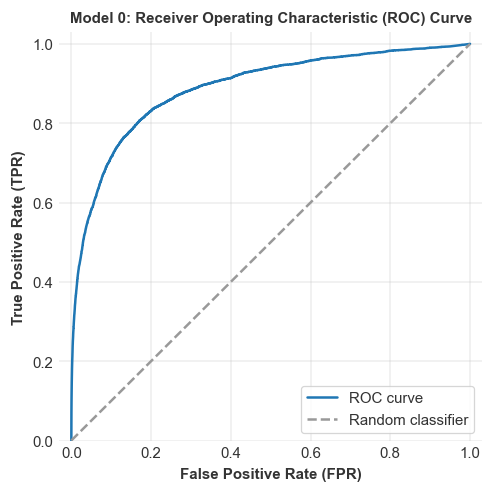

In [13]:
plot_utils.plot_roc_curve(
    p_valid_fpr,
    p_valid_tpr,
    model_idx,
    save=SAVE_PLOTS,
    output_dir=OUTPUT_DIR,
    file_name=f"model_{model_idx}_roc_curve",
)

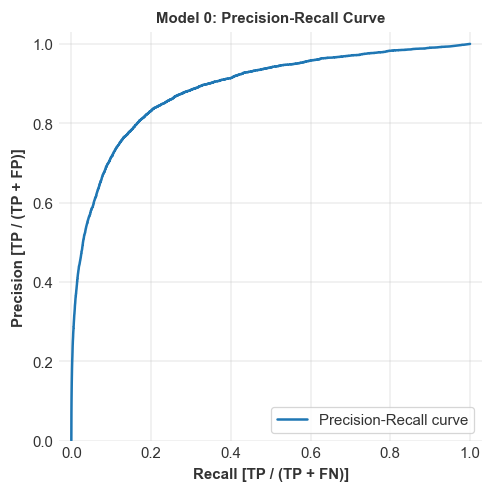

In [14]:
plot_utils.plot_precision_recall_curve(
    p_valid_fpr,
    p_valid_tpr,
    model_idx,
    save=SAVE_PLOTS,
    output_dir=OUTPUT_DIR,
    file_name=f"model_{model_idx}_precision_recall_curve",
)

#### Feature importance


In [15]:
importance_gain = gbm.feature_importance(importance_type="gain")

df_imp_gain = pd.DataFrame(
    {"feature": features, "importance_gain": importance_gain}
).sort_values("importance_gain", ascending=False)

df_imp_gain.to_csv(
    f"{OUTPUT_DIR}/model_{model_idx}_feature_importance_gain.csv",
    index=False,
)
df_imp_gain

,feature,importance_gain
29,no_abnorm,296097.370057
52,mage_c,261636.018625
25,ab_nicu,243458.305900
40,ca_disor,123841.951951
48,dbwt,91096.226398
32,ca_cchd,64680.483001
6,gestrec10,45160.270377
50,wtgain,37482.651713
51,bmi,28305.508397
49,pwgt_r,23295.069372


### Evaluation subset for permutation importances and SHAP analysis


In [16]:
X_eval, y_eval = ml_utils.build_explain_set(gbm, X_valid, y_valid, categorical)

In [17]:
model_wrapped = ml_utils.LGBMEstimator(gbm)

In [18]:
result = permutation_importance(
    model_wrapped,
    X_eval,
    y_eval,
    scoring=ml_utils.ap_scorer,
    n_repeats=20,
    n_jobs=8,
    random_state=RANDOM_SEED,
)

perm_importance = pd.DataFrame(
    {
        "feature": X_eval.columns,
        "importance_mean": result.importances_mean,
        "importance_std": result.importances_std,
    }
).sort_values("importance_mean", ascending=False)

perm_importance.to_csv(
    f"{OUTPUT_DIR}/model_{model_idx}_permutation_importance.csv",
    index=False,
)
perm_importance

,feature,importance_mean,importance_std
32,ca_cchd,1.365714e-02,4.096731e-04
52,mage_c,1.307237e-02,3.948294e-04
40,ca_disor,1.185963e-02,3.111217e-04
48,dbwt,2.451392e-03,4.202739e-04
6,gestrec10,2.203753e-03,4.158830e-04
25,ab_nicu,1.890785e-03,5.385500e-04
29,no_abnorm,1.686513e-03,4.470103e-04
20,dmeth_rec,1.453286e-03,3.100216e-04
41,meduc,7.724967e-04,1.613470e-04
24,ab_aven6,7.216182e-04,1.906725e-04


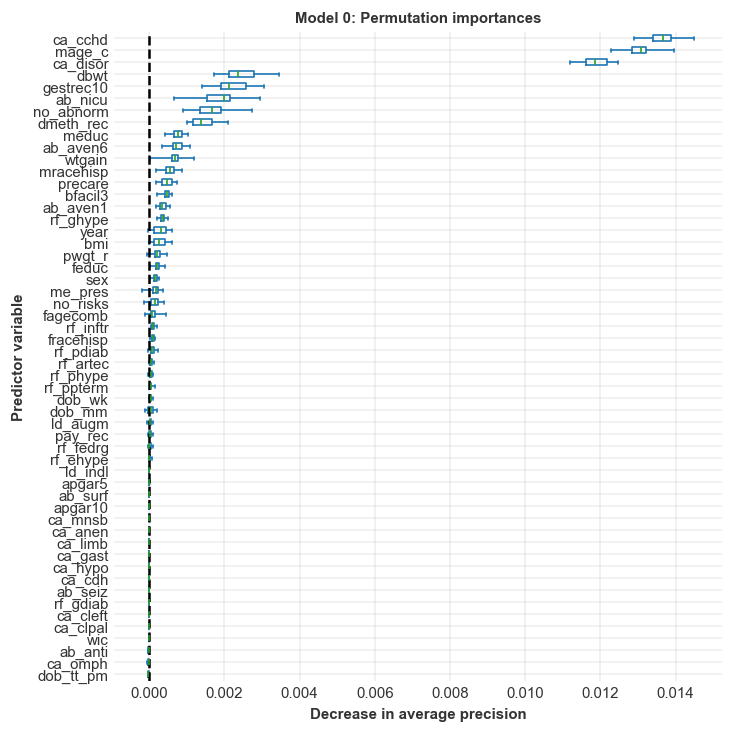

In [19]:
plot_utils.plot_permutation_importances(
    result,
    X_eval,
    model_idx,
    save=SAVE_PLOTS,
    output_dir=OUTPUT_DIR,
    file_name=f"model_{model_idx}_permutation_importances",
)

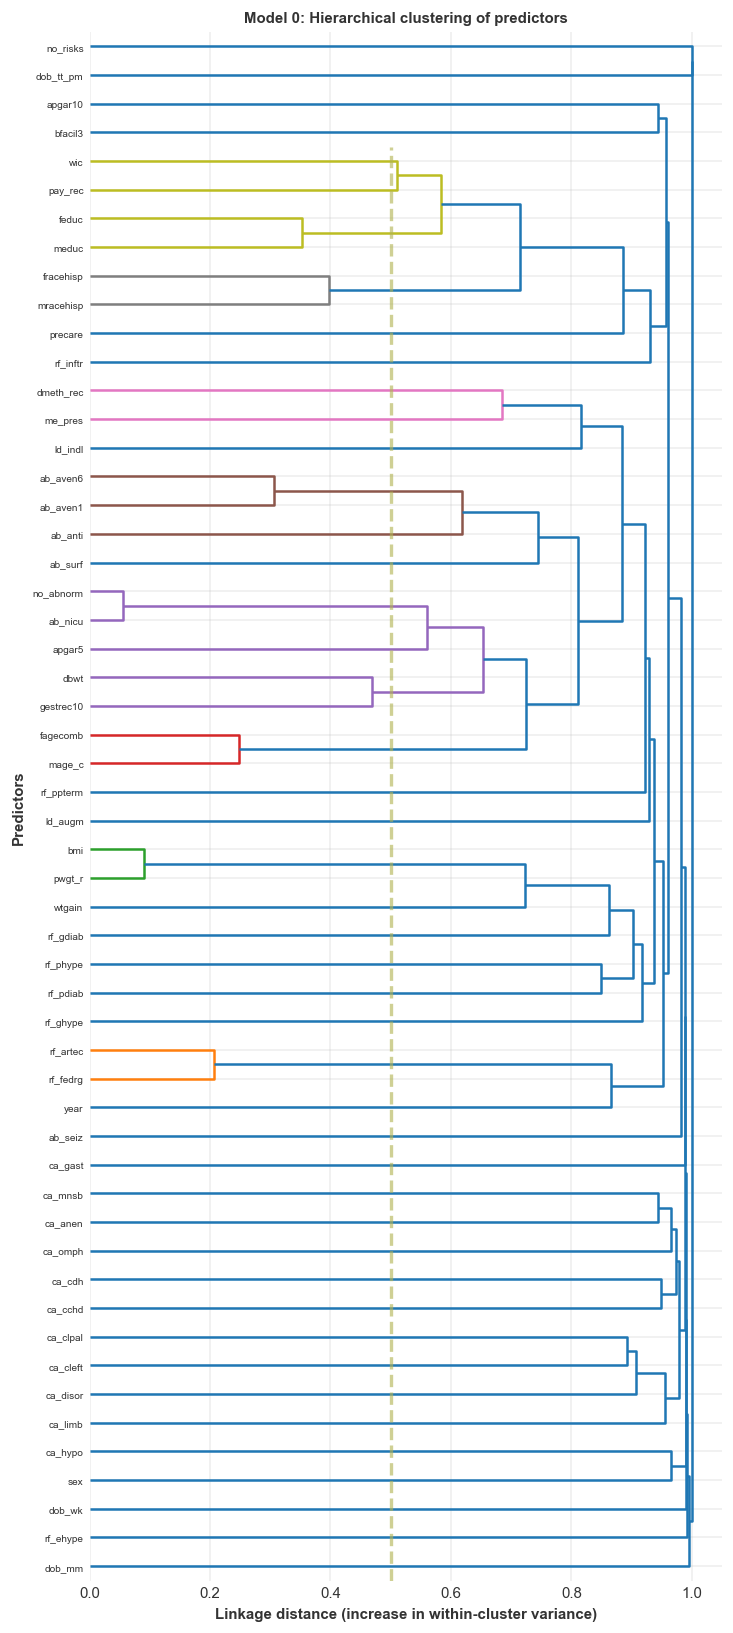

In [20]:
distance, corr = stats_utils.distance_corr_dissimilarity(X_eval)
condensed = squareform(distance, checks=True)
dist_linkage = hierarchy.linkage(condensed, method="average")
dendro_labels = X_eval.columns.to_list()
dendro = plot_utils.plot_dendrogram(
    dist_linkage,
    dendro_labels,
    model_idx,
    save=SAVE_PLOTS,
    output_dir=OUTPUT_DIR,
    file_name=f"model_{model_idx}_dendrogram",
)

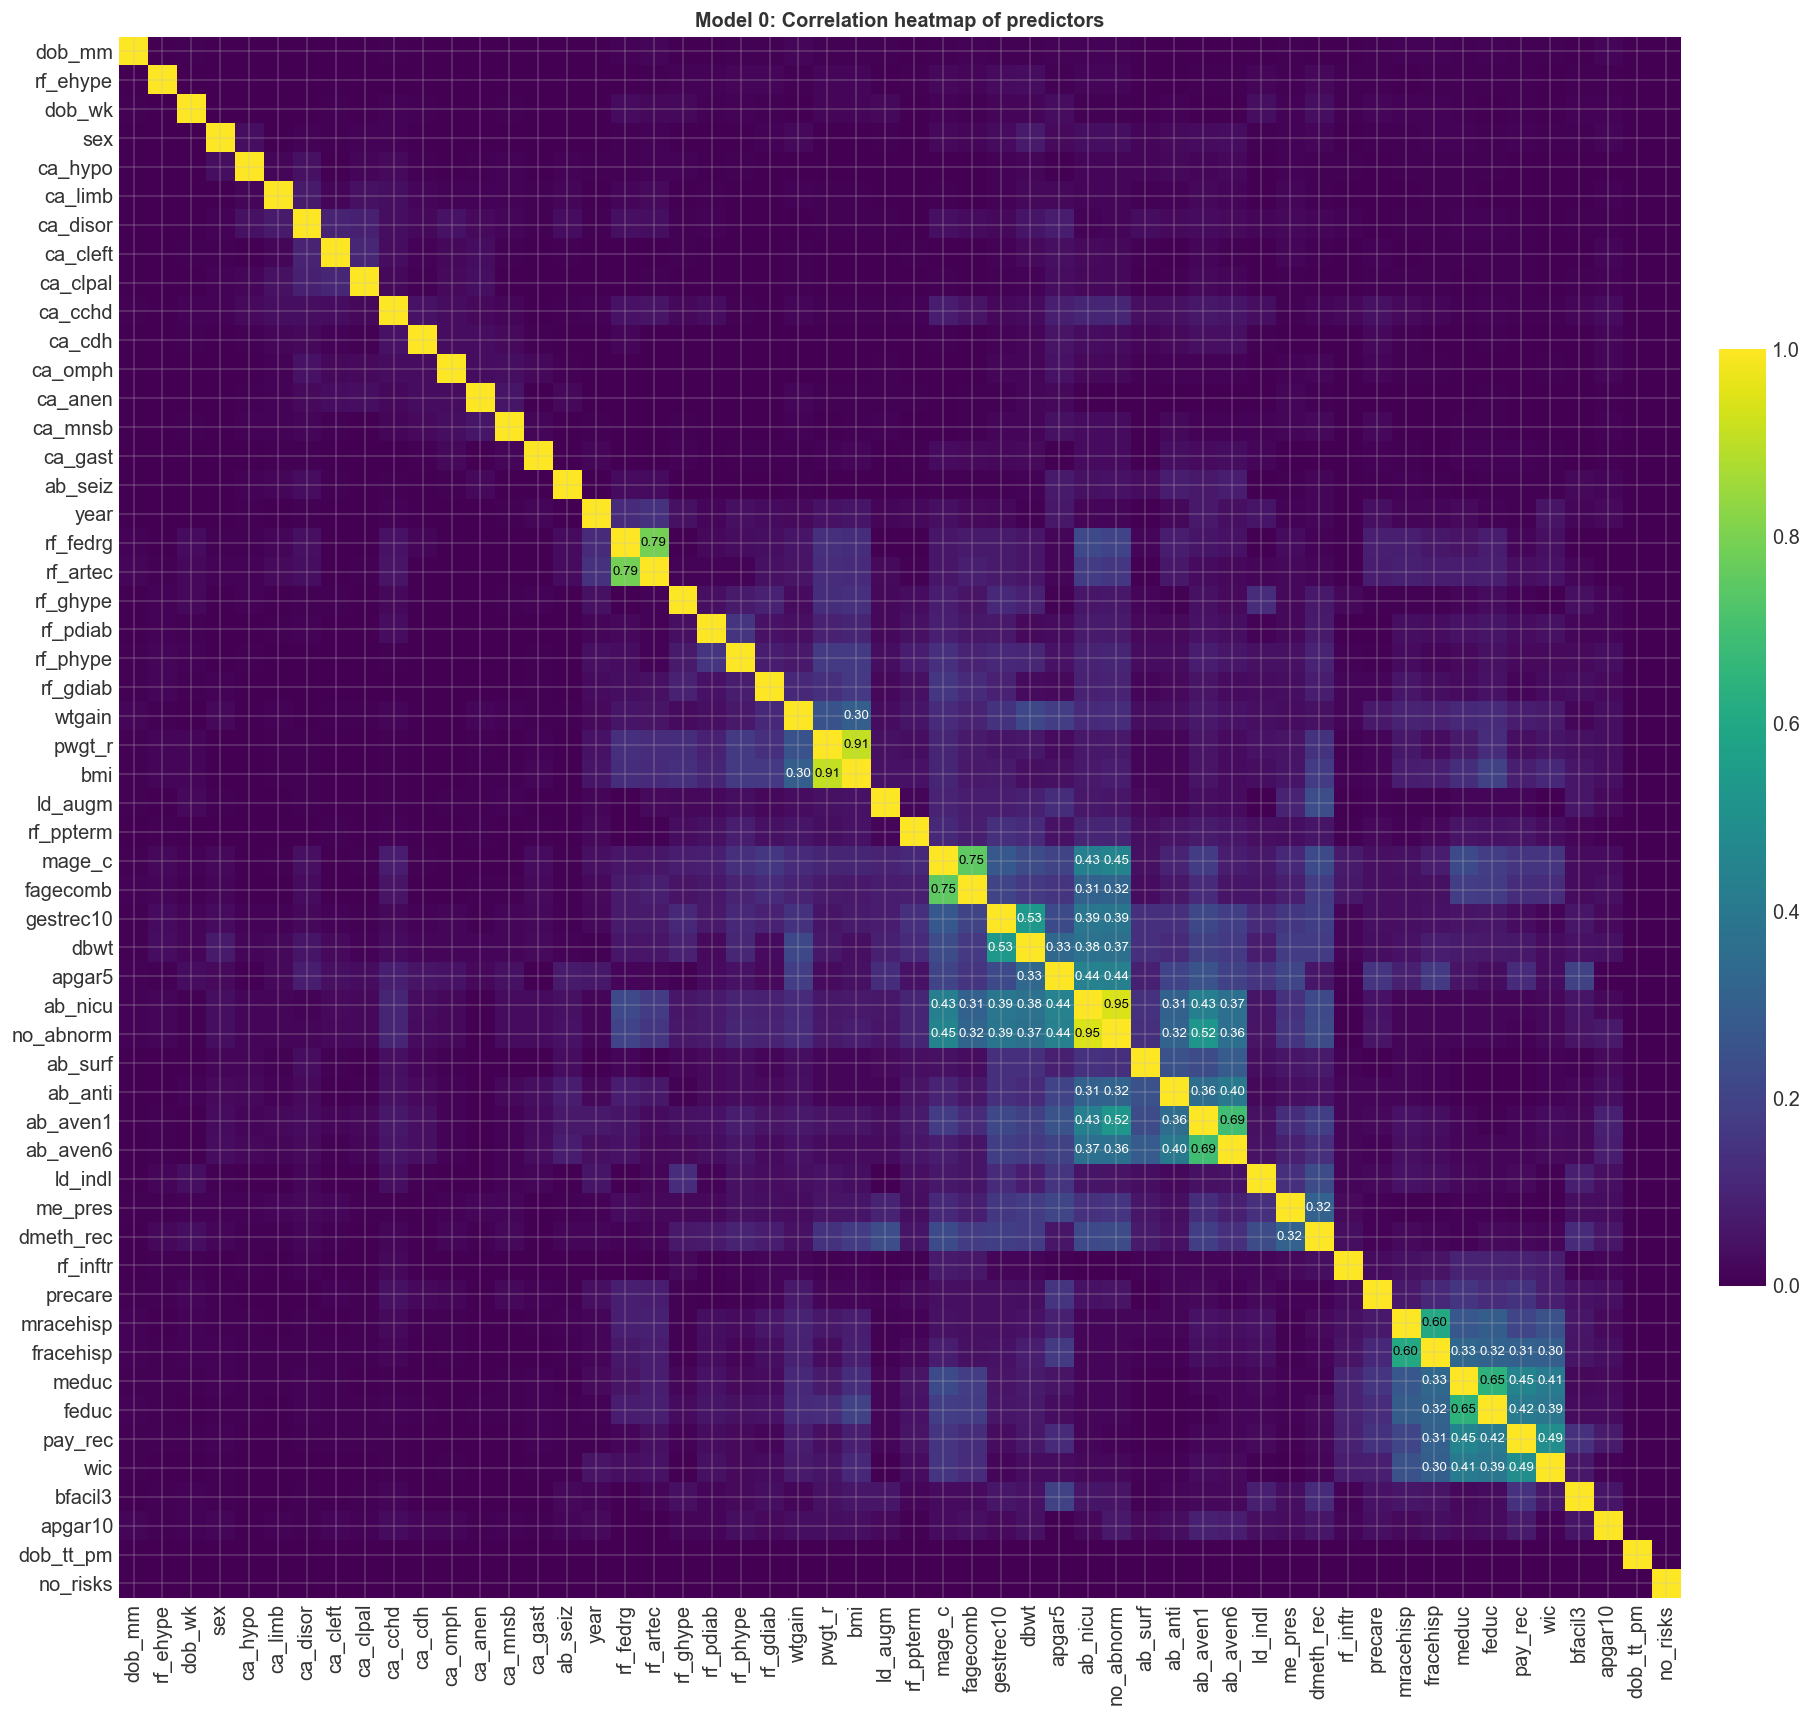

In [21]:
plot_utils.plot_correlation_heatmap(
    corr,
    dendro,
    label_threshold=0.3,
    model_idx=model_idx,
    save=SAVE_PLOTS,
    output_dir=OUTPUT_DIR,
    file_name=f"model_{model_idx}_correlation_heatmap",
)

In [22]:
explainer = shap.TreeExplainer(
    gbm, feature_perturbation="tree_path_dependent", model_output="raw"
)

explanation = explainer(X_eval)

clustering = shap.utils.hclust(
    X_eval, y_eval, linkage="average", random_state=RANDOM_SEED
)

shap_values = explanation.values

shap_importance = pd.DataFrame(
    {
        "feature": X_eval.columns,
        "mean_abs_shap": np.mean(np.abs(shap_values), axis=0),
    }
).sort_values("mean_abs_shap", ascending=False)

shap_importance.to_csv(
    f"{OUTPUT_DIR}/model_{model_idx}_shap_importance.csv",
    index=False,
)
shap_importance

v:\miniforge3\envs\data-stats-models-ml\Lib\site-packages\shap\utils\_clustering.py:170: UserWarning: No/low signal found from feature 0 (this is typically caused by constant or near-constant features)! Cluster distances can't be computed for it (so setting all redundancy distances to 1).
  warnings.warn(
v:\miniforge3\envs\data-stats-models-ml\Lib\site-packages\shap\utils\_clustering.py:170: UserWarning: No/low signal found from feature 1 (this is typically caused by constant or near-constant features)! Cluster distances can't be computed for it (so setting all redundancy distances to 1).
  warnings.warn(
v:\miniforge3\envs\data-stats-models-ml\Lib\site-packages\shap\utils\_clustering.py:170: UserWarning: No/low signal found from feature 2 (this is typically caused by constant or near-constant features)! Cluster distances can't be computed for it (so setting all redundancy distances to 1).
  warnings.warn(
v:\miniforge3\envs\data-stats-models-ml\Lib\site-packages\shap\utils\_clusterin

,feature,mean_abs_shap
29,no_abnorm,0.746665
52,mage_c,0.692883
25,ab_nicu,0.387272
48,dbwt,0.294739
6,gestrec10,0.244733
42,mracehisp,0.089602
32,ca_cchd,0.081335
40,ca_disor,0.081247
50,wtgain,0.069887
41,meduc,0.044982


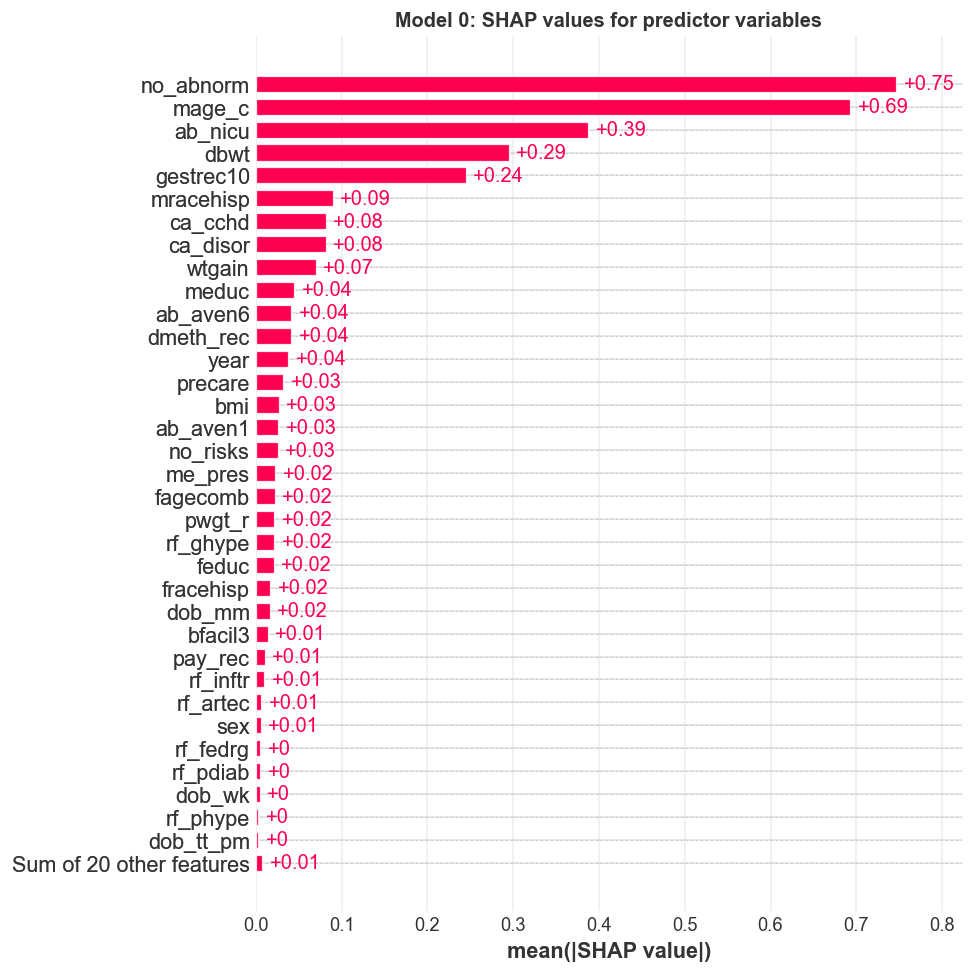

<Figure size 492x348 with 0 Axes>

In [23]:
with plt.rc_context({"axes.titlesize": 12}):
    plot = plt.figure(figsize=(8, 8))
    ax = plot.subplots()
    ax.set_title(f"Model {model_idx}: SHAP values for predictor variables")
    shap.plots.bar(explanation, max_display=35, ax=ax)
    if SAVE_PLOTS:
        plt.savefig(
            f"{OUTPUT_DIR}/model_{model_idx}_shap_bar.png", dpi=300, bbox_inches="tight"
        )
        plt.savefig(f"{OUTPUT_DIR}/model_{model_idx}_shap_bar.svg", bbox_inches="tight")
    plt.show()

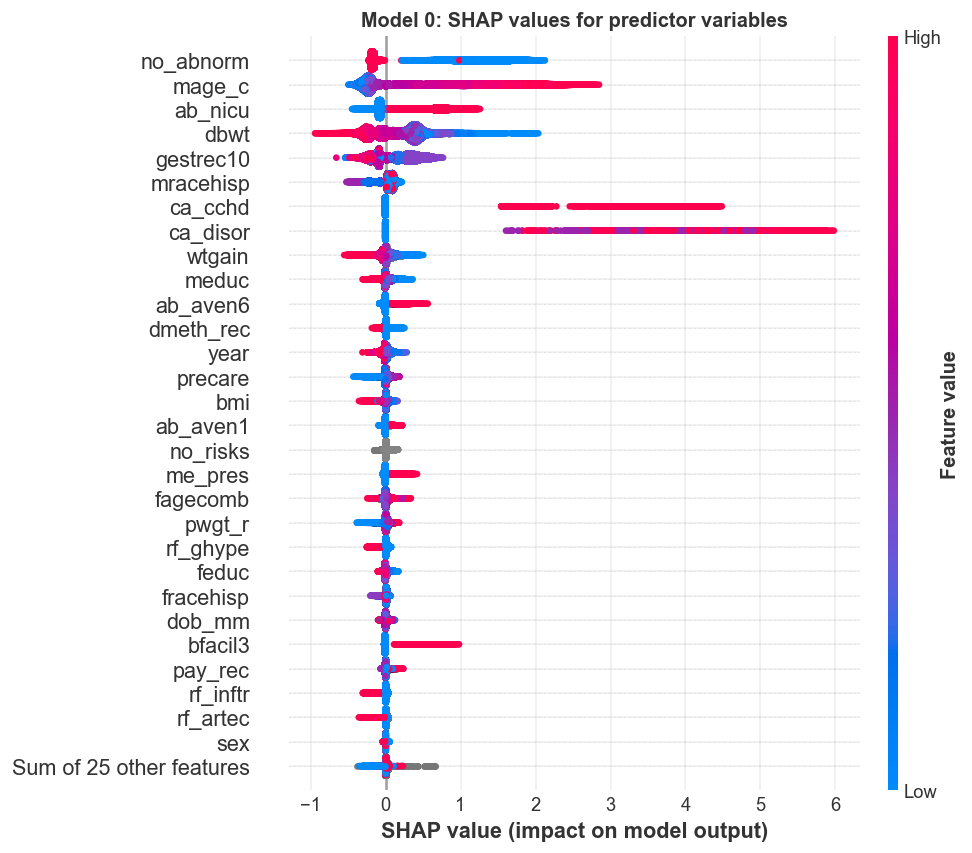

<Figure size 492x348 with 0 Axes>

In [24]:
with plt.rc_context({"axes.titlesize": 12}):
    plot = plt.figure()
    ax = plot.subplots()
    ax.set_title(f"Model {model_idx}: SHAP values for predictor variables")
    shap.plots.beeswarm(explanation, max_display=30, plot_size=(8, 7))
    if SAVE_PLOTS:
        plt.savefig(
            f"{OUTPUT_DIR}/model_{model_idx}_shap_beeswarm.png",
            dpi=300,
            bbox_inches="tight",
        )
        plt.savefig(
            f"{OUTPUT_DIR}/model_{model_idx}_shap_beeswarm.svg",
            bbox_inches="tight",
        )
    plt.show()

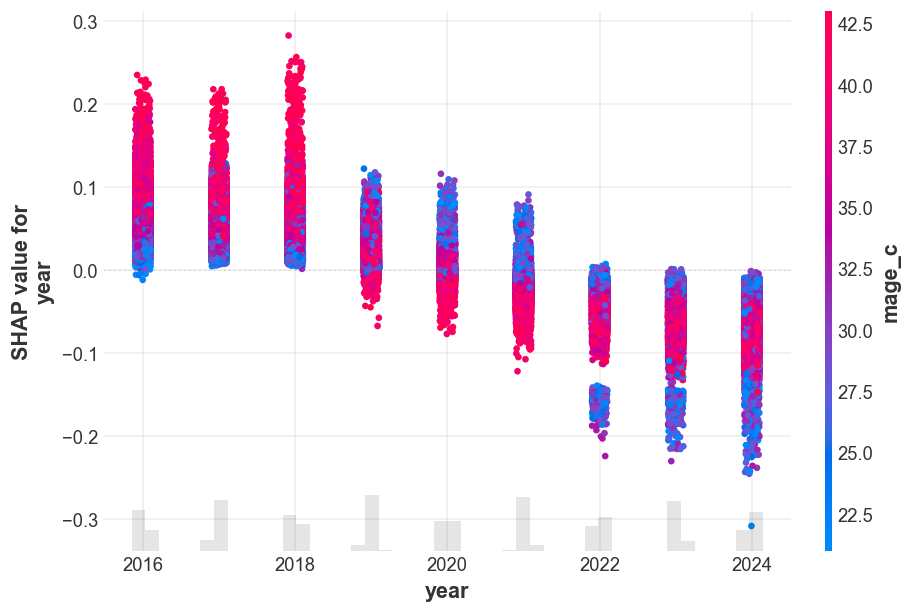

<Figure size 492x348 with 0 Axes>

In [25]:
ax = shap.plots.scatter(explanation[:, "year"], color=explanation[:, "mage_c"])
# ax.set_title(f"Model {model_idx}: SHAP values for year vs maternal age")
if SAVE_PLOTS:
    plt.savefig(
        f"{OUTPUT_DIR}/model_{model_idx}_shap_year_vs_maternal_age.png",
        dpi=300,
        bbox_inches="tight",
    )
    plt.savefig(
        f"{OUTPUT_DIR}/model_{model_idx}_shap_year_vs_maternal_age.svg",
        bbox_inches="tight",
    )
plt.show()

## Model 1


In [ ]:
features_to_remove_0 = [
    "ld_augm",
    "rf_ehype",
    "sex",
    "pwgt_r",
]

X_train = X_train.drop(columns=features_to_remove_0)
X_valid = X_valid.drop(columns=features_to_remove_0)
X_cal = X_cal.drop(columns=features_to_remove_0)

features = X_train.columns.to_list()
categorical = [col for col in categorical if col not in features_to_remove_0]

train_data = lgb.Dataset(
    X_train, label=y_train, categorical_feature=categorical, free_raw_data=False
)

valid_data = lgb.Dataset(
    X_valid,
    label=y_valid,
    categorical_feature=categorical,
    reference=train_data,
    free_raw_data=False,
)

model_idx = 1
model_name = (
    f"Model {model_idx} (after removing {len(features_to_remove_0)} predictors)"
)

print(f"Features removed: {features_to_remove_0}")
print(f"Features remaining: {features}")
print(f"Number of features in {model_name}: {X_train.shape[1]}")

In [ ]:
gbm = lgb.train(
    params,
    train_data,
    num_boost_round=NUM_BOOST_ROUND,
    valid_sets=[train_data, valid_data],
    valid_names=["train", "valid"],
    callbacks=[
        early_stopping(stopping_rounds=EARLY_STOPPING_ROUNDS),
        log_evaluation(period=10),
    ],
)

best_iter = gbm.best_iteration
gbm.save_model(
    f"{OUTPUT_DIR}/model_{model_idx}.txt",
    num_iteration=best_iter,
)

In [ ]:
p_valid = gbm.predict(X_valid, num_iteration=best_iter)

In [ ]:
metrics_df, p_valid_fpr, p_valid_tpr, p_valid_thresholds = ml_utils.get_metrics(
    y_valid, p_valid, K=10000, thr=0.01
)

metrics_df.to_csv(
    f"{OUTPUT_DIR}/model_{model_idx}_validation_metrics.csv",
    index=False,
)

metrics_df

In [ ]:
plot_utils.plot_roc_curve(
    p_valid_fpr,
    p_valid_tpr,
    model_idx,
    save=SAVE_PLOTS,
    output_dir=OUTPUT_DIR,
    file_name=f"model_{model_idx}_roc_curve",
)

In [ ]:
plot_utils.plot_precision_recall_curve(
    p_valid_fpr,
    p_valid_tpr,
    model_idx,
    save=SAVE_PLOTS,
    output_dir=OUTPUT_DIR,
    file_name=f"model_{model_idx}_precision_recall_curve",
)

In [ ]:
importance_gain = gbm.feature_importance(importance_type="gain")

df_imp_gain = pd.DataFrame(
    {"feature": features, "importance_gain": importance_gain}
).sort_values("importance_gain", ascending=False)

df_imp_gain.to_csv(
    f"{OUTPUT_DIR}/model_{model_idx}_feature_importance_gain.csv",
    index=False,
)
df_imp_gain

In [ ]:
X_eval, y_eval = ml_utils.build_explain_set(gbm, X_valid, y_valid, categorical)

model_wrapped = ml_utils.LGBMEstimator(gbm)

In [ ]:
result = permutation_importance(
    model_wrapped,
    X_eval,
    y_eval,
    scoring=ml_utils.ap_scorer,
    n_repeats=20,
    n_jobs=8,
    random_state=RANDOM_SEED,
)

perm_importance = pd.DataFrame(
    {
        "feature": X_eval.columns,
        "importance_mean": result.importances_mean,
        "importance_std": result.importances_std,
    }
).sort_values("importance_mean", ascending=False)

perm_importance.to_csv(
    f"{OUTPUT_DIR}/model_{model_idx}_permutation_importance.csv",
    index=False,
)
perm_importance

In [ ]:
plot_utils.plot_permutation_importances(
    result,
    X_eval,
    model_idx,
    save=SAVE_PLOTS,
    output_dir=OUTPUT_DIR,
    file_name=f"model_{model_idx}_permutation_importances",
)

In [ ]:
distance, corr = stats_utils.distance_corr_dissimilarity(X_eval)
condensed = squareform(distance, checks=True)
dist_linkage = hierarchy.linkage(condensed, method="average")
dendro_labels = X_eval.columns.to_list()
dendro = plot_utils.plot_dendrogram(
    dist_linkage,
    dendro_labels,
    model_idx,
    save=SAVE_PLOTS,
    output_dir=OUTPUT_DIR,
    file_name=f"model_{model_idx}_dendrogram",
)

In [ ]:
plot_utils.plot_correlation_heatmap(
    corr,
    dendro,
    label_threshold=0.3,
    model_idx=model_idx,
    save=SAVE_PLOTS,
    output_dir=OUTPUT_DIR,
    file_name=f"model_{model_idx}_correlation_heatmap",
)

In [ ]:
explainer = shap.TreeExplainer(
    gbm, feature_perturbation="tree_path_dependent", model_output="raw"
)

explanation = explainer(X_eval)

clustering = shap.utils.hclust(
    X_eval, y_eval, linkage="average", random_state=RANDOM_SEED
)

shap_values = explanation.values

shap_importance = pd.DataFrame(
    {
        "feature": X_eval.columns,
        "mean_abs_shap": np.mean(np.abs(shap_values), axis=0),
    }
).sort_values("mean_abs_shap", ascending=False)

shap_importance.to_csv(
    f"{OUTPUT_DIR}/model_{model_idx}_shap_importance.csv",
    index=False,
)
shap_importance

In [ ]:
shap_importance["feature"].tolist()

In [ ]:
with plt.rc_context({"axes.titlesize": 12}):
    plot = plt.figure(figsize=(8, 8))
    ax = plot.subplots()
    ax.set_title(f"Model {model_idx}: SHAP values for predictor variables")
    shap.plots.bar(explanation, max_display=35, ax=ax)
    if SAVE_PLOTS:
        plt.savefig(
            f"{OUTPUT_DIR}/model_{model_idx}_shap_bar.png", dpi=300, bbox_inches="tight"
        )
        plt.savefig(f"{OUTPUT_DIR}/model_{model_idx}_shap_bar.svg", bbox_inches="tight")
    plt.show()

In [ ]:
with plt.rc_context({"axes.titlesize": 12}):
    plot = plt.figure()
    ax = plot.subplots()
    ax.set_title(f"Model {model_idx}: SHAP values for predictor variables")
    shap.plots.beeswarm(explanation, max_display=30, plot_size=(8, 7))
    if SAVE_PLOTS:
        plt.savefig(
            f"{OUTPUT_DIR}/model_{model_idx}_shap_beeswarm.png",
            dpi=300,
            bbox_inches="tight",
        )
        plt.savefig(
            f"{OUTPUT_DIR}/model_{model_idx}_shap_beeswarm.svg",
            bbox_inches="tight",
        )
    plt.show()

In [ ]:
shap.plots.scatter(explanation[:, "year"], color=explanation[:, "mage_c"])
plt.title(f"Model {model_idx}: SHAP values for year vs maternal age")
if SAVE_PLOTS:
    plt.savefig(
        f"{OUTPUT_DIR}/model_{model_idx}_shap_year_vs_maternal_age.png",
        dpi=300,
        bbox_inches="tight",
    )
    plt.savefig(
        f"{OUTPUT_DIR}/model_{model_idx}_shap_year_vs_maternal_age.svg",
        bbox_inches="tight",
    )
plt.show()

## Model 2


In [ ]:
features_to_remove_1 = [
    "rf_ppterm",
]

X_train = X_train.drop(columns=features_to_remove_1)
X_valid = X_valid.drop(columns=features_to_remove_1)
X_cal = X_cal.drop(columns=features_to_remove_1)

features = X_train.columns.to_list()
categorical = [col for col in categorical if col not in features_to_remove_1]

train_data = lgb.Dataset(
    X_train, label=y_train, categorical_feature=categorical, free_raw_data=False
)

valid_data = lgb.Dataset(
    X_valid,
    label=y_valid,
    categorical_feature=categorical,
    reference=train_data,
    free_raw_data=False,
)

model_idx = 2
model_name = (
    f"Model {model_idx} (after removing {len(features_to_remove_1)} predictors)"
)

print(f"Features removed: {features_to_remove_1}")
print(f"Features remaining: {features}")
print(f"Number of features in {model_name}: {X_train.shape[1]}")

In [ ]:
gbm = lgb.train(
    params,
    train_data,
    num_boost_round=NUM_BOOST_ROUND,
    valid_sets=[train_data, valid_data],
    valid_names=["train", "valid"],
    callbacks=[
        early_stopping(stopping_rounds=EARLY_STOPPING_ROUNDS),
        log_evaluation(period=10),
    ],
)

best_iter = gbm.best_iteration
gbm.save_model(
    f"{OUTPUT_DIR}/model_{model_idx}.txt",
    num_iteration=best_iter,
)

In [ ]:
p_valid = gbm.predict(X_valid, num_iteration=best_iter)

In [ ]:
metrics_df, p_valid_fpr, p_valid_tpr, p_valid_thresholds = ml_utils.get_metrics(
    y_valid, p_valid, K=10000, thr=0.01
)

metrics_df.to_csv(
    f"{OUTPUT_DIR}/model_{model_idx}_validation_metrics.csv",
    index=False,
)

metrics_df

In [ ]:
plot_utils.plot_roc_curve(
    p_valid_fpr,
    p_valid_tpr,
    model_idx,
    save=SAVE_PLOTS,
    output_dir=OUTPUT_DIR,
    file_name=f"model_{model_idx}_roc_curve",
)

In [ ]:
plot_utils.plot_precision_recall_curve(
    p_valid_fpr,
    p_valid_tpr,
    model_idx,
    save=SAVE_PLOTS,
    output_dir=OUTPUT_DIR,
    file_name=f"model_{model_idx}_precision_recall_curve",
)

In [ ]:
importance_gain = gbm.feature_importance(importance_type="gain")

df_imp_gain = pd.DataFrame(
    {"feature": features, "importance_gain": importance_gain}
).sort_values("importance_gain", ascending=False)

df_imp_gain.to_csv(
    f"{OUTPUT_DIR}/model_{model_idx}_feature_importance_gain.csv",
    index=False,
)
df_imp_gain

In [ ]:
X_eval, y_eval = ml_utils.build_explain_set(gbm, X_valid, y_valid, categorical)

model_wrapped = ml_utils.LGBMEstimator(gbm)

In [ ]:
result = permutation_importance(
    model_wrapped,
    X_eval,
    y_eval,
    scoring=ml_utils.ap_scorer,
    n_repeats=20,
    n_jobs=8,
    random_state=RANDOM_SEED,
)

perm_importance = pd.DataFrame(
    {
        "feature": X_eval.columns,
        "importance_mean": result.importances_mean,
        "importance_std": result.importances_std,
    }
).sort_values("importance_mean", ascending=False)

perm_importance.to_csv(
    f"{OUTPUT_DIR}/model_{model_idx}_permutation_importance.csv",
    index=False,
)
perm_importance

In [ ]:
plot_utils.plot_permutation_importances(
    result,
    X_eval,
    model_idx,
    save=SAVE_PLOTS,
    output_dir=OUTPUT_DIR,
    file_name=f"model_{model_idx}_permutation_importances",
)

In [ ]:
distance, corr = stats_utils.distance_corr_dissimilarity(X_eval)
condensed = squareform(distance, checks=True)
dist_linkage = hierarchy.linkage(condensed, method="average")
dendro_labels = X_eval.columns.to_list()
dendro = plot_utils.plot_dendrogram(
    dist_linkage,
    dendro_labels,
    model_idx,
    save=SAVE_PLOTS,
    output_dir=OUTPUT_DIR,
    file_name=f"model_{model_idx}_dendrogram",
)

In [ ]:
plot_utils.plot_correlation_heatmap(
    corr,
    dendro,
    label_threshold=0.3,
    model_idx=model_idx,
    save=SAVE_PLOTS,
    output_dir=OUTPUT_DIR,
    file_name=f"model_{model_idx}_correlation_heatmap",
)

In [ ]:
explainer = shap.TreeExplainer(
    gbm, feature_perturbation="tree_path_dependent", model_output="raw"
)

explanation = explainer(X_eval)

clustering = shap.utils.hclust(
    X_eval, y_eval, linkage="average", random_state=RANDOM_SEED
)

shap_values = explanation.values

shap_importance = pd.DataFrame(
    {
        "feature": X_eval.columns,
        "mean_abs_shap": np.mean(np.abs(shap_values), axis=0),
    }
).sort_values("mean_abs_shap", ascending=False)

shap_importance.to_csv(
    f"{OUTPUT_DIR}/model_{model_idx}_shap_importance.csv",
    index=False,
)
shap_importance

In [ ]:
shap_importance["feature"].tolist()

In [ ]:
with plt.rc_context({"axes.titlesize": 12}):
    plot = plt.figure(figsize=(8, 8))
    ax = plot.subplots()
    ax.set_title(f"Model {model_idx}: SHAP values for predictor variables")
    shap.plots.bar(explanation, max_display=35, ax=ax)
    if SAVE_PLOTS:
        plt.savefig(
            f"{OUTPUT_DIR}/model_{model_idx}_shap_bar.png", dpi=300, bbox_inches="tight"
        )
        plt.savefig(f"{OUTPUT_DIR}/model_{model_idx}_shap_bar.svg", bbox_inches="tight")
    plt.show()

In [ ]:
with plt.rc_context({"axes.titlesize": 12}):
    plot = plt.figure()
    ax = plot.subplots()
    ax.set_title(f"Model {model_idx}: SHAP values for predictor variables")
    shap.plots.beeswarm(explanation, max_display=30, plot_size=(8, 7))
    if SAVE_PLOTS:
        plt.savefig(
            f"{OUTPUT_DIR}/model_{model_idx}_shap_beeswarm.png",
            dpi=300,
            bbox_inches="tight",
        )
        plt.savefig(
            f"{OUTPUT_DIR}/model_{model_idx}_shap_beeswarm.svg",
            bbox_inches="tight",
        )
    plt.show()

In [ ]:
shap.plots.scatter(explanation[:, "year"], color=explanation[:, "mage_c"])
plt.title(f"Model {model_idx}: SHAP values for year vs maternal age")
if SAVE_PLOTS:
    plt.savefig(
        f"{OUTPUT_DIR}/model_{model_idx}_shap_year_vs_maternal_age.png",
        dpi=300,
        bbox_inches="tight",
    )
    plt.savefig(
        f"{OUTPUT_DIR}/model_{model_idx}_shap_year_vs_maternal_age.svg",
        bbox_inches="tight",
    )
plt.show()

## Calibration


In [ ]:
p_cal_raw = gbm.predict(X_cal, num_iteration=gbm.best_iteration, raw_score=True)

In [ ]:
calibrator = LogisticRegression(solver="lbfgs", max_iter=1000)
calibrator.fit(p_cal_raw.reshape(-1, 1), y_cal)

In [ ]:
def predict_proba_calibrated(gbm, calibrator, X_new, num_iteration=None):
    p_raw = gbm.predict(X_new, num_iteration=num_iteration, raw_score=True)
    return calibrator.predict_proba(p_raw.reshape(-1, 1))[:, 1]

## Prediction


In [ ]:
p_valid_cal = predict_proba_calibrated(
    gbm, calibrator, X_valid, num_iteration=gbm.best_iteration
)

p_valid_raw = gbm.predict(X_valid, num_iteration=gbm.best_iteration, raw_score=False)

print("best_iteration:", gbm.best_iteration)
print("mean raw prob:", float(p_valid_raw.mean()))
print("mean cal prob:", float(p_valid_cal.mean()))


print("Raw logloss:", log_loss(y_valid, p_valid_raw, labels=[0, 1]))
print("Cal logloss:", log_loss(y_valid, p_valid_cal, labels=[0, 1]))
print("Raw brier:  ", brier_score_loss(y_valid, p_valid_raw))
print("Cal brier:  ", brier_score_loss(y_valid, p_valid_cal))

In [ ]:
def tail_calibration_table(y, p, fracs=(1e-2, 1e-3, 1e-4, 1e-5)):
    """
    Compare predicted vs observed event rates in the top fracs of scores.

    Parameters
    ----------
    y : array-like (0/1)
    p : array-like (probabilities)
    fracs : iterable of floats
        Fractions like 1e-3 for top 0.1%.

    Returns
    -------
    DataFrame with k, predicted mean, observed rate, and counts.
    """
    y = np.asarray(y).astype(int)
    p = np.asarray(p).astype(float)

    order = np.argsort(-p)
    y_sorted = y[order]
    p_sorted = p[order]

    N = len(y)
    rows = []
    for f in fracs:
        k = max(1, int(round(N * f)))
        y_top = y_sorted[:k]
        p_top = p_sorted[:k]

        obs_rate = y_top.mean()
        pred_rate = p_top.mean()

        tp = int(y_top.sum())
        fp = int(k - tp)

        rows.append(
            {
                "top_frac": f,
                "k": k,
                "pred_rate_mean": pred_rate,
                "obs_rate": obs_rate,
                "tp": tp,
                "fp": fp,
                "pred_minus_obs": pred_rate - obs_rate,
                "ratio_pred_to_obs": (pred_rate / obs_rate) if obs_rate > 0 else np.nan,
            }
        )

    return pd.DataFrame(rows)

In [ ]:
fracs = (1e-2, 1e-3, 1e-4, 1e-5)  # 1%, 0.1%, 0.01%, 0.001%

calibration_table_raw = tail_calibration_table(y_valid, p_valid_raw, fracs=fracs)
calibration_table_cal = tail_calibration_table(y_valid, p_valid_cal, fracs=fracs)

calibration_table_raw["model"] = "raw"
calibration_table_cal["model"] = "calibrated"
calibration_table_combined = pd.concat(
    [calibration_table_raw, calibration_table_cal], ignore_index=True
)

calibration_table_combined.to_csv(
    f"{OUTPUT_DIR}/model_{model_idx}_tail_calibration_table.csv",
    index=False,
)

calibration_table_combined

In [ ]:
gbm.save_model(
    f"{OUTPUT_DIR}/final_model_{model_idx}.txt",
    num_iteration=best_iter,
)

In [ ]:
joblib.dump(calibrator, f"{OUTPUT_DIR}/final_calibrator.joblib")

meta = {
    "features": list(X_train.columns),
    "best_iteration": int(getattr(gbm, "best_iteration", 0) or 0),
    "calibration_input": "raw_score",  # or "prob"
}

joblib.dump(meta, f"{OUTPUT_DIR}/final_model_meta.joblib")

In [ ]:
X_full = df[features]
p_full_cal = predict_proba_calibrated(
    gbm, calibrator, X_full, num_iteration=gbm.best_iteration
)

In [ ]:
df["p_ds_lb_pred_01"] = p_full_cal

In [ ]:
df[["year", "p_ds_lb_pred"]].groupby("year").sum().reset_index()

In [ ]:
import duckdb

con = duckdb.connect("./data/us_births.db")

In [ ]:
con.execute(
    """
    ALTER TABLE us_births ADD COLUMN IF NOT EXISTS p_ds_lb_pred_01 DOUBLE;
    """
)
con.execute("DROP TABLE IF EXISTS ds_lb_pred_01")
con.execute(f"CREATE TABLE ds_lb_pred_01 (id BIGINT, p_ds_lb_pred DOUBLE)")

In [ ]:
con.execute(
    """
    INSERT INTO ds_lb_pred_01 (id, p_ds_lb_pred)
    SELECT id, p_ds_lb_pred_01
    FROM df
    """
)

In [ ]:
con.execute(
    """
    UPDATE us_births b
    SET p_ds_lb_pred_01 = p.p_ds_lb_pred
    FROM ds_lb_pred_01 p
    WHERE b.id = p.id;
    """
)

In [ ]:
con.execute("DROP TABLE IF EXISTS ds_lb_pred_01")

In [ ]:
con.close()